In [14]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines
from scipy.stats import kde
import matplotlib.colors as clr
import statsmodels.api as sm
import itertools as it

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

In [15]:

data = '/Users/amyel/research/SMASH_project/datafiles/parsec_decamsdss_3.0gyr.fits.gz'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [16]:
u_des = objs['DECAM_U']
g_des = objs['DES_G']
r_des = objs['DES_R']
i_des = objs['DES_I']
z_des = objs['DES_Z']
feh_des = objs['FEH']
u_g_des = u_des - g_des
g_r_des = g_des - r_des


In [17]:
u_g_des = u_g_des + .3

In [18]:

#apply shift found in isochrone_minimize_residuals_01OCT2019
u_g_dex = u_g_des - .005
g_r_dex = g_r_des - .005

In [19]:
data = '/Users/amyel/research/SMASH_project/datafiles/new_SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [20]:
#deredden calibration sample
u_cal = (objs["U"]-(4.239*objs["EBV"]))
g_cal = (objs["G"]-(3.303*objs["EBV"]))
i_cal = (objs["I"]-(1.263*objs["EBV"]))
r_cal = (objs["R"]-(2.285*objs["EBV"]))
feh_cal = objs["FEH"]
u_g_cal = u_cal - g_cal
g_r_cal = g_cal - r_cal

# Below, plot of calibration data overlaid on isochrone data

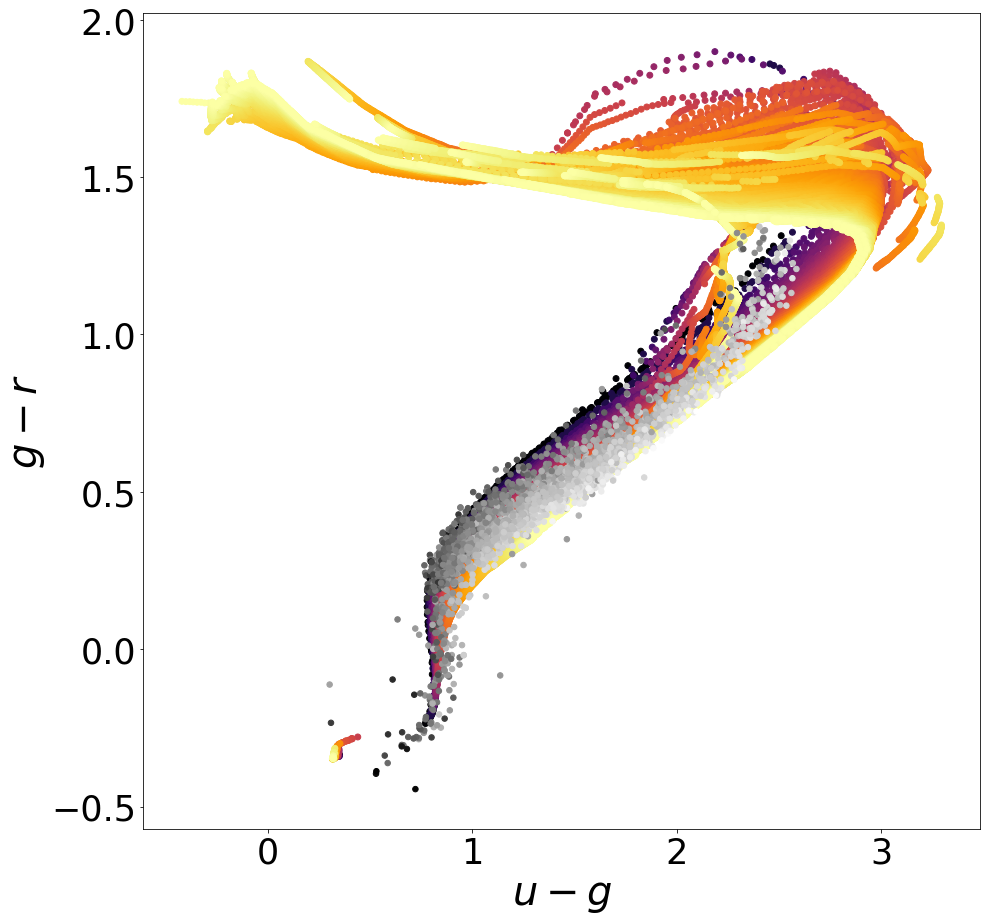

In [21]:
fig, ax = plt.subplots(figsize=(15,15))
plt.scatter(u_g_des,g_r_des,c=feh_des,s=35,cmap='inferno')
plt.scatter(u_g_cal,g_r_cal,c=feh_cal,s=30,cmap='gray')
plt.xlabel('$u-g$',fontsize=40)
plt.ylabel('$g-r$',fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=35)


In [22]:
#cuts and shifts from isochrone_minimize_residuals_01OCT2019
#reduce area to around selection box
selected = np.where((u_g_des>=0.4)&(u_g_des<=1.5)&(g_r_des>=-0.1)&(g_r_des<=0.5))
u_g_des = u_g_des[selected]
g_r_des = g_r_des[selected]
feh_des = feh_des[selected]






# Below, plot: color space to just around area of SMASH MSTO stars

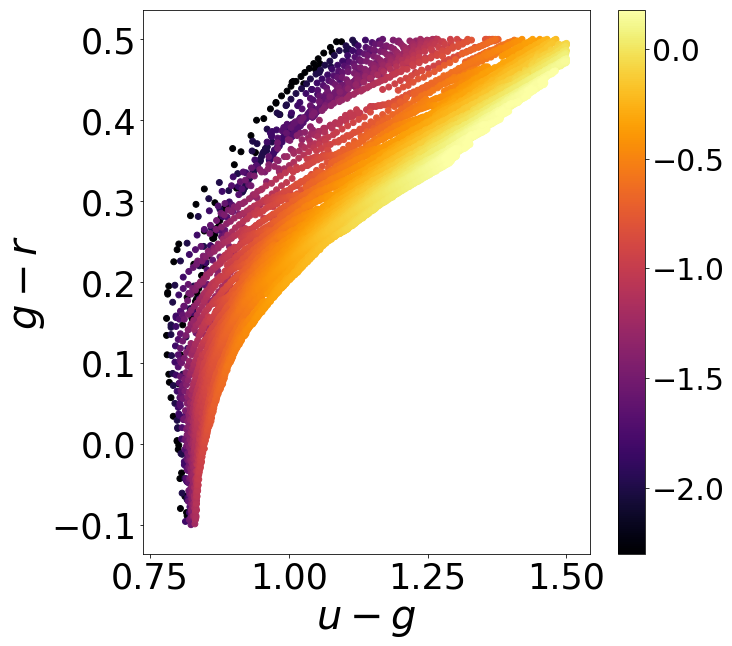

In [23]:

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(u_g_des,g_r_des,c=feh_des,s=35,cmap='inferno')
plt.xlabel('$u-g$',fontsize=40)
plt.ylabel('$g-r$',fontsize=40)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
ax.tick_params(axis='both', which='major', labelsize=35)

In [24]:
#following: https://github.com/JoshuaPovick/Magellanic_Ages/blob/master/NEW_PARSEC.ipynb
#Create a list of all possible models
y1 = u_g_des
y2 = g_r_des
y1_y2 = np.multiply(y1,y2)
y1sq = y1**2
y2sq = y2**2
y1sq_y2 = np.multiply(y1sq,y2)
y2sq_y1 = np.multiply(y2sq,y1)
y1th = y1**3
y2th = y2**3




models = []
models_str = []
all_var_str = ['y1','y2','y1_y2','y1sq','y2sq','y1sq_y2','y2sq_y1','y1th','y2th']
all_var = [y1,y2,y1_y2,y1sq,y2sq,y1sq_y2,y2sq_y1,y1th,y2th]
       

In [25]:
for i in range(2, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))

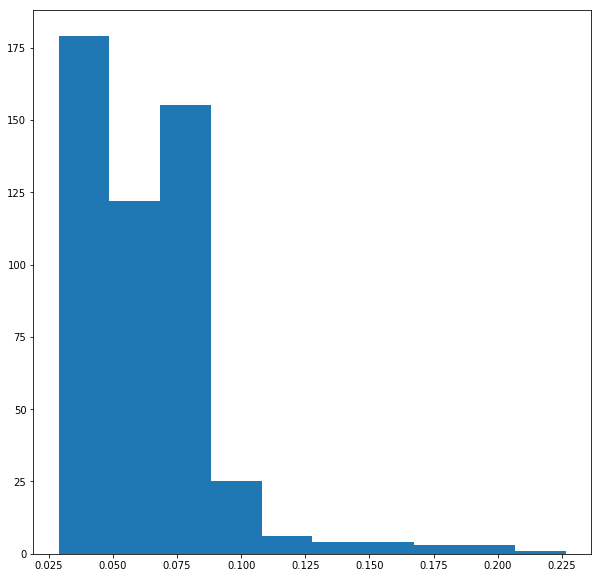

(array([465]),)
0.028915676243470453
[array(['y1', 'y2', 'y1_y2', 'y1sq', 'y2sq_y1', 'y1th', 'y2th'],
      dtype='<U7')]
[array([-37.06896793,  94.31453667, -31.60664069,  41.00180578,
       -78.27252217, -38.65094243,  20.2718878 ,  22.51781102])]


In [26]:
#fit all models
model_mads = []
model_params = []
model_res = []
for i in range(len(models)):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(feh_des,pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - feh_des
    model_res.append(max(np.absolute(residual)))
    model_mads.append(mad(residual))
    model_params.append(np.asarray(model.params))
    
plt.figure(figsize=[10,10])
plt.hist(model_mads)
plt.show()
    
best = np.where(model_mads == min(model_mads))
print(best)
print(min(model_mads))
print(np.array(models_str)[best])
print(np.asarray(model_params)[best])


In [27]:


#evaluate each polynomial for:
#x= u_g_des
#y= g_r_des
fitted = []

for i in np.arange(0,len(model_params)):
    temp = []
    temp.append(model_params[i][0]*(np.ones(len(y1))))
    for j in np.arange(1,len(model_params[i])):
        if models_str[i][(j-1)] == 'y1':
            temp.append((y1*model_params[i][j]))
        elif models_str[i][(j-1)] == 'y2':
            temp.append((y2*model_params[i][j]))
        elif models_str[i][(j-1)] == 'y1_y2':
            temp.append((y1*y2*model_params[i][j]))
        elif models_str[i][(j-1)] == 'y1sq':
            temp.append((y1**2)*model_params[i][j])
        elif models_str[i][(j-1)] == 'y2sq':
            temp.append((y2**2)*model_params[i][j])
        elif models_str[i][(j-1)] == 'y1sq_y2':
            temp.append(y2*(y1**2)*model_params[i][j])
        elif models_str[i][(j-1)] == 'y2sq_y1':
            temp.append((y1*model_params[i][j])*(y2**2))
        elif models_str[i][(j-1)] == 'y1th':
            temp.append((y1**3)*model_params[i][j])
        elif models_str[i][(j-1)] == 'y2th':
            temp.append((y2**3)*model_params[i][j])

        
    #print(temp)
    #print(len(temp))
    sums = temp[0]
    for k in np.arange(1,len(temp)):
        sums += temp[k]
    fitted.append((sums))
        
        
        

In [28]:
norm = []
for model in fitted:
    residuals = feh_des - model
    temp = 0
    for element in residuals:
        temp += (element**2)
    norm.append(np.sqrt(np.sum(temp)))
        
        
        

# Historgram of norm (square root of sum of squares) of residuals of fitted models

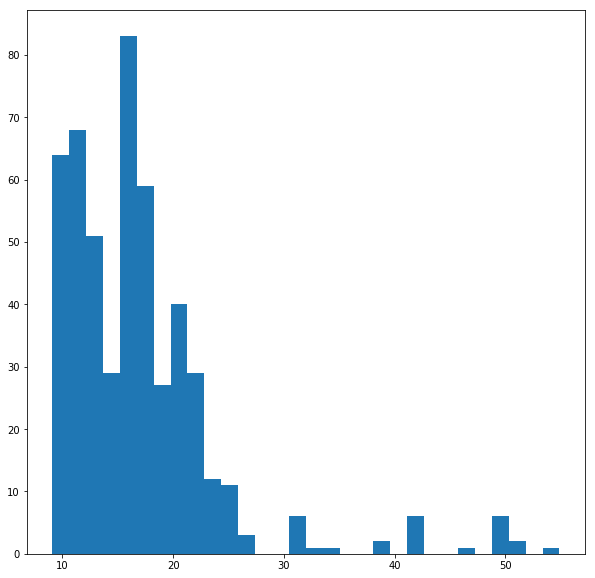

In [29]:
plt.figure(figsize=[10,10])
plt.hist(norm,bins=30)
plt.show()

In [30]:
small, = np.where(np.asarray(norm)<9.33)

In [31]:
len(small)

3

# Below: Plot the residuals with the three lowest norms (square root of sum of squares) 

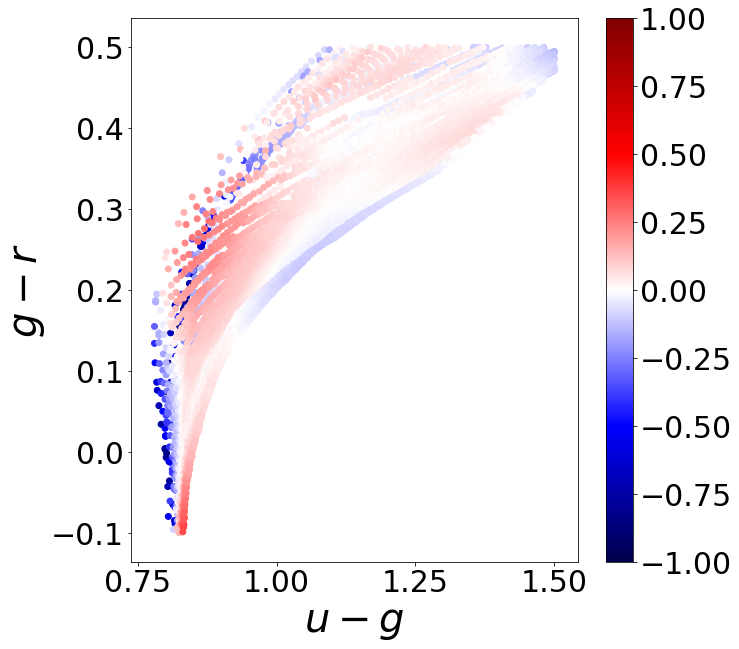

[-2.30079634 -2.30730374 -2.36933215 ...  0.17919748  0.17346256
  0.21475713]
492
['y1' 'y2' 'y1_y2' 'y1sq' 'y2sq' 'y1sq_y2' 'y2sq_y1' 'y1th']
[-30.06583531  71.98190966 -16.56255116  43.50519234 -59.6700197
 -49.62232936 -25.52389602  33.81312681  17.91330847]


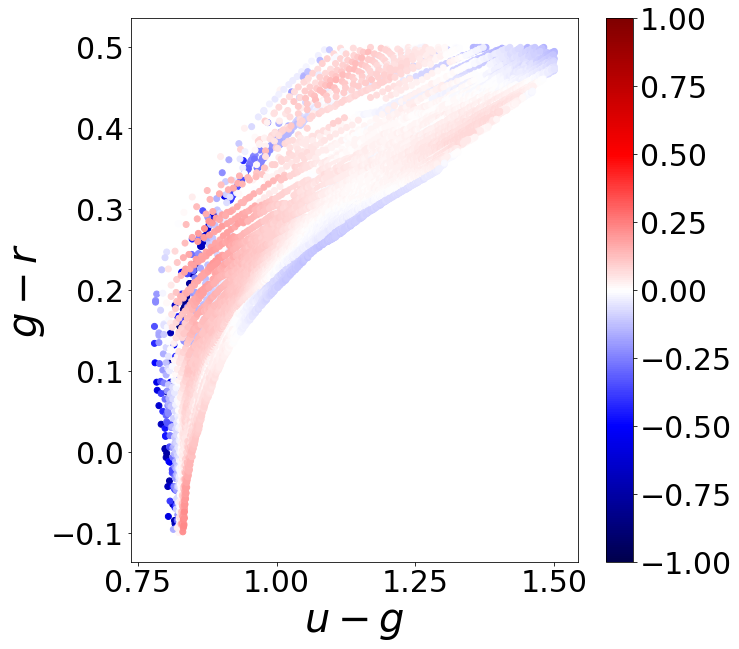

[-2.31376233 -2.31900134 -2.32679846 ...  0.17422811  0.15890149
  0.18691162]
499
['y1' 'y1_y2' 'y1sq' 'y2sq' 'y1sq_y2' 'y2sq_y1' 'y1th' 'y2th']
[-25.55064061  55.48728734  17.94445459 -41.70837105 -55.93200314
 -19.87457644  50.59258781  12.27970056 -10.66435247]


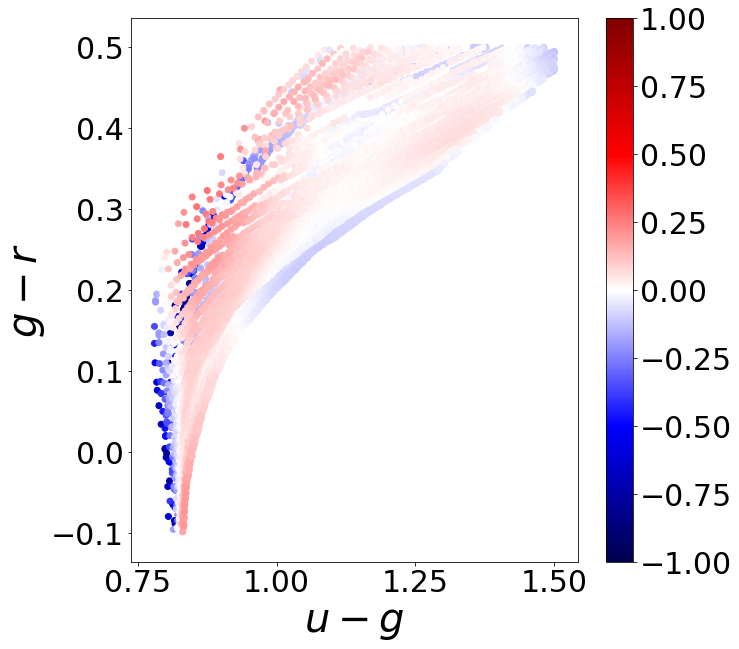

[-2.45375329 -2.46175676 -2.51845055 ...  0.19637436  0.19205279
  0.23614831]
501
['y1' 'y2' 'y1_y2' 'y1sq' 'y2sq' 'y1sq_y2' 'y2sq_y1' 'y1th' 'y2th']
[ -31.80316573   83.05507026  -36.33626095  112.05948183  -80.29311333
 -103.37033309  -80.34825251  112.50100437   29.67121544  -32.70582575]


In [32]:
#plot residuals 

for index in small:
    fig, ax = plt.subplots(figsize=(10,10))    
    plt.scatter(u_g_des,g_r_des,c=(feh_des-fitted[index]),cmap='seismic',vmin=-1,vmax=1)
    cbar = plt.colorbar()
    plt.xlabel('$u-g$',fontsize=40)
    plt.ylabel('$g-r$',fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=30)
    cbar.ax.tick_params(labelsize=30) 

    plt.show()
    print(fitted[index])
    print(index)
    print(models_str[index])
    print(model_params[index])
    

In [33]:
x = np.arange(-4,1,.001)

In [34]:
blue = mlines.Line2D([], [], color='b', marker='o',linestyle='None',markersize=20, label='[Fe/H]$_\mathregular{DECam}$ - [Fe/H]$_\mathregular{Polynomial}$')
red = mlines.Line2D([], [], color='r', marker='None',linestyle='--',linewidth=10, label='Median')

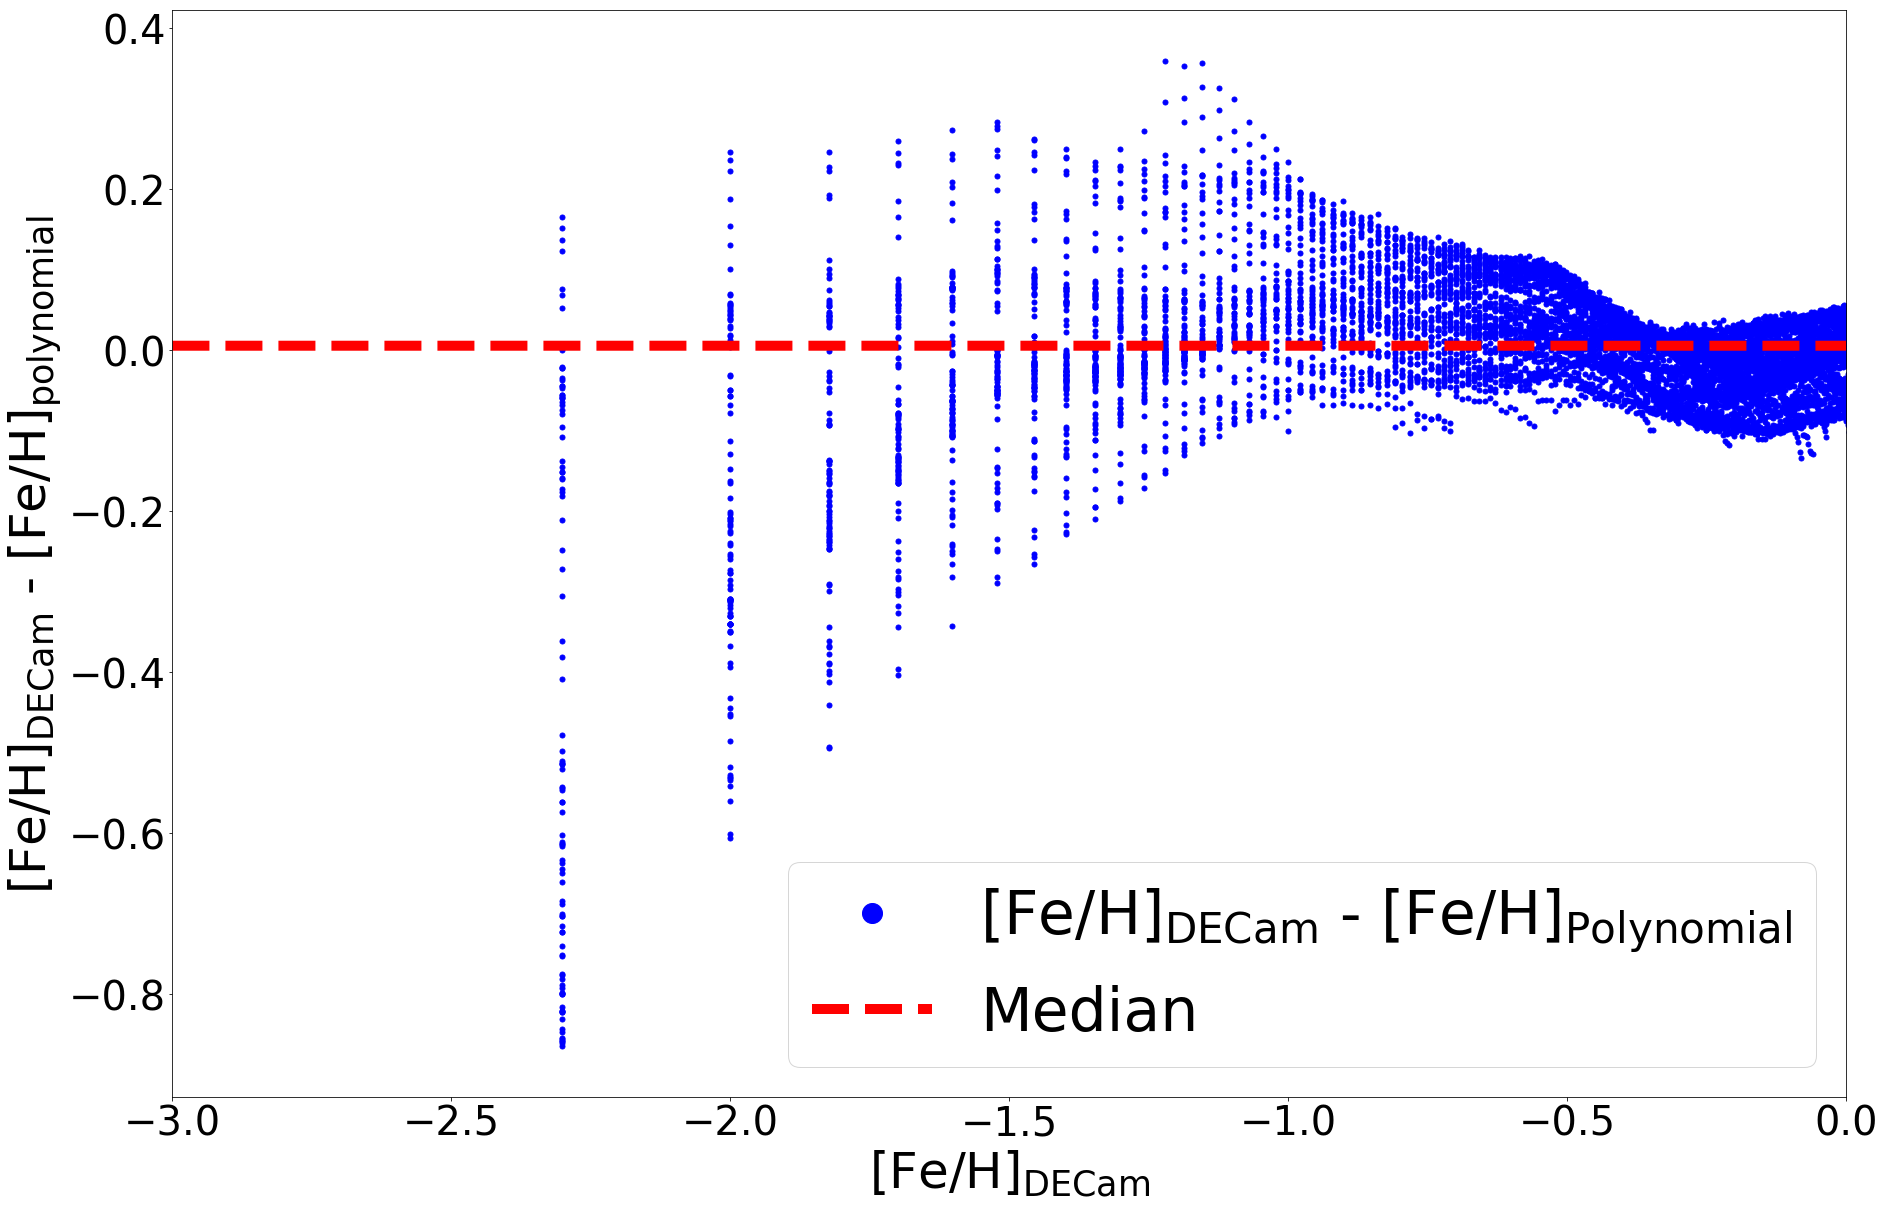

492
0.005567501497040439
['y1' 'y2' 'y1_y2' 'y1sq' 'y2sq' 'y1sq_y2' 'y2sq_y1' 'y1th']
[-30.06583531  71.98190966 -16.56255116  43.50519234 -59.6700197
 -49.62232936 -25.52389602  33.81312681  17.91330847]


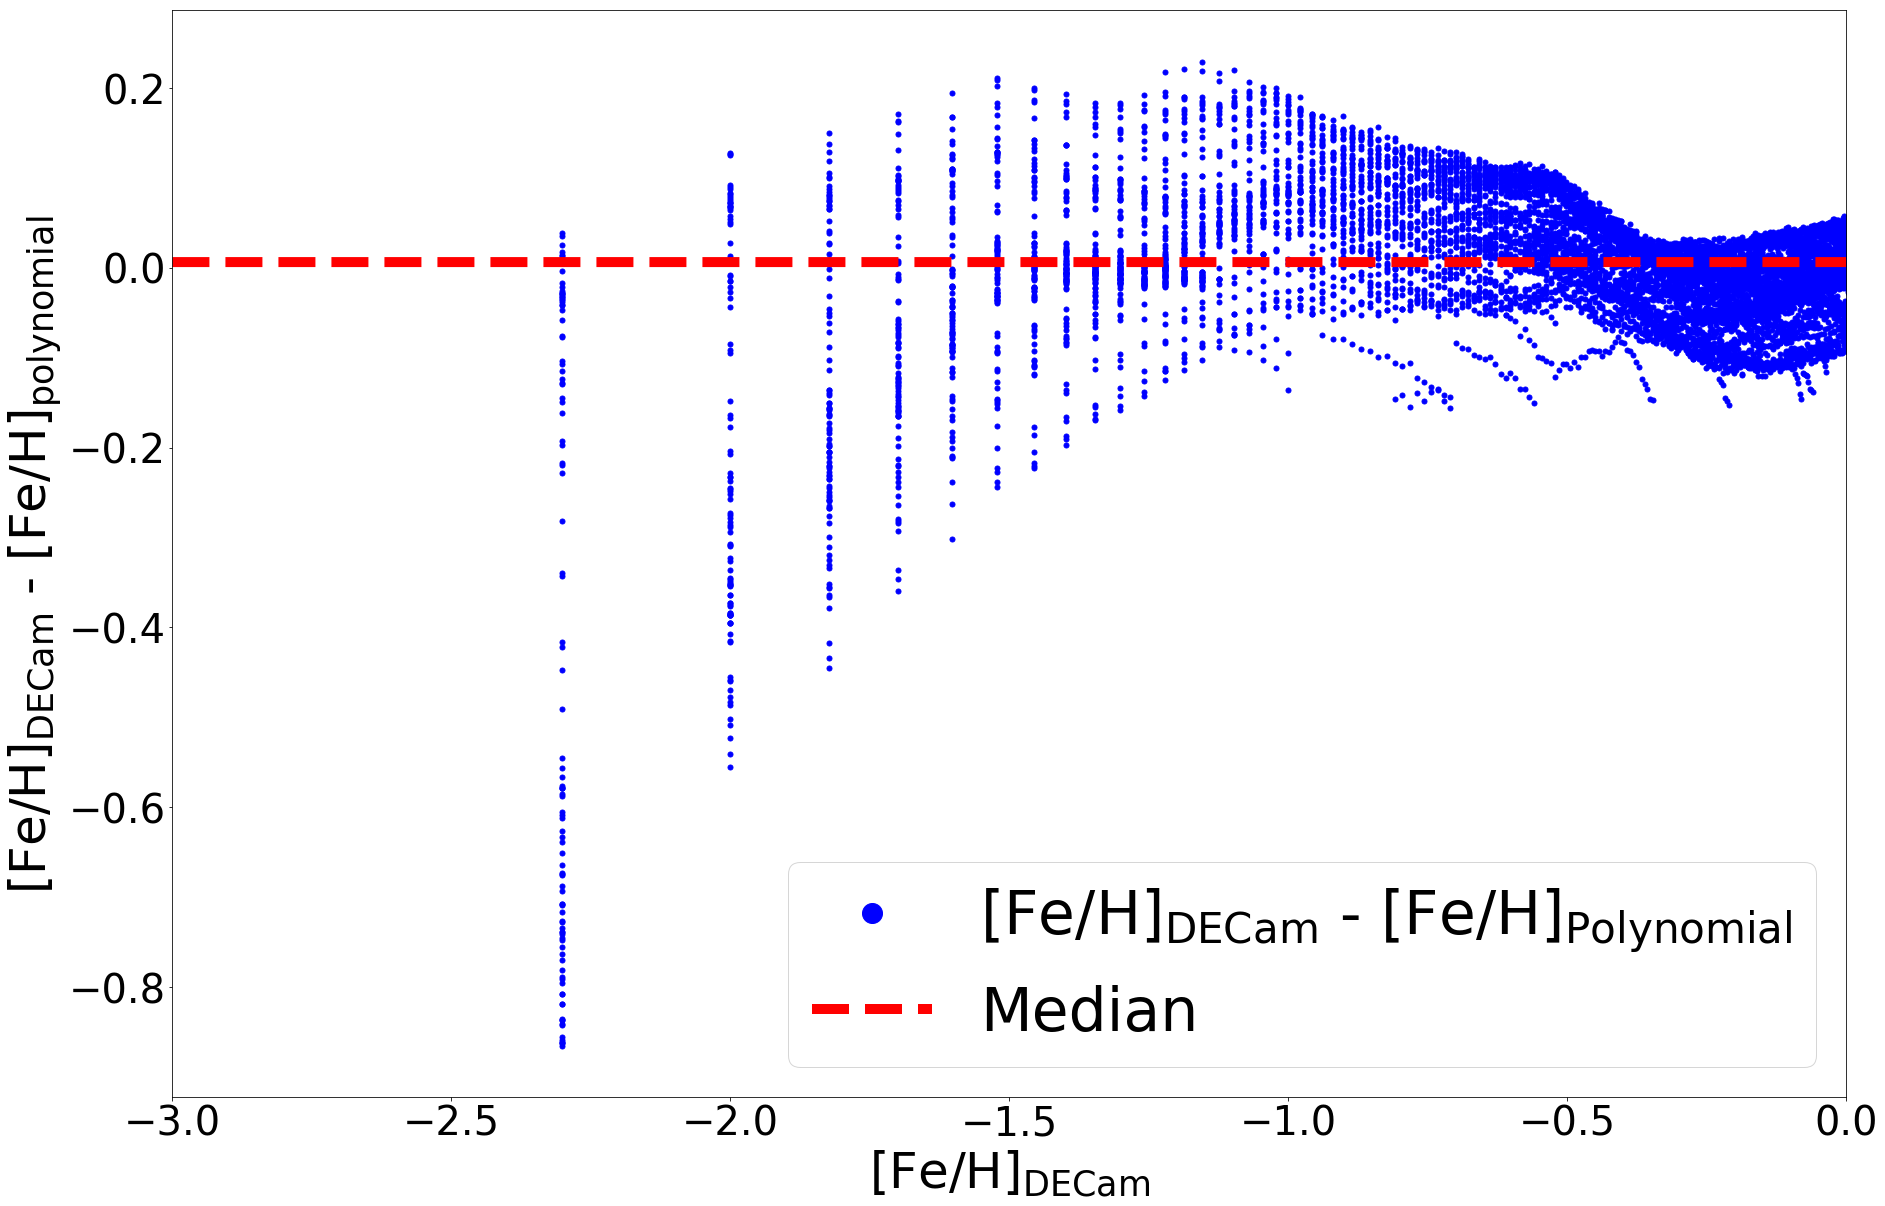

499
0.006510375566234572
['y1' 'y1_y2' 'y1sq' 'y2sq' 'y1sq_y2' 'y2sq_y1' 'y1th' 'y2th']
[-25.55064061  55.48728734  17.94445459 -41.70837105 -55.93200314
 -19.87457644  50.59258781  12.27970056 -10.66435247]


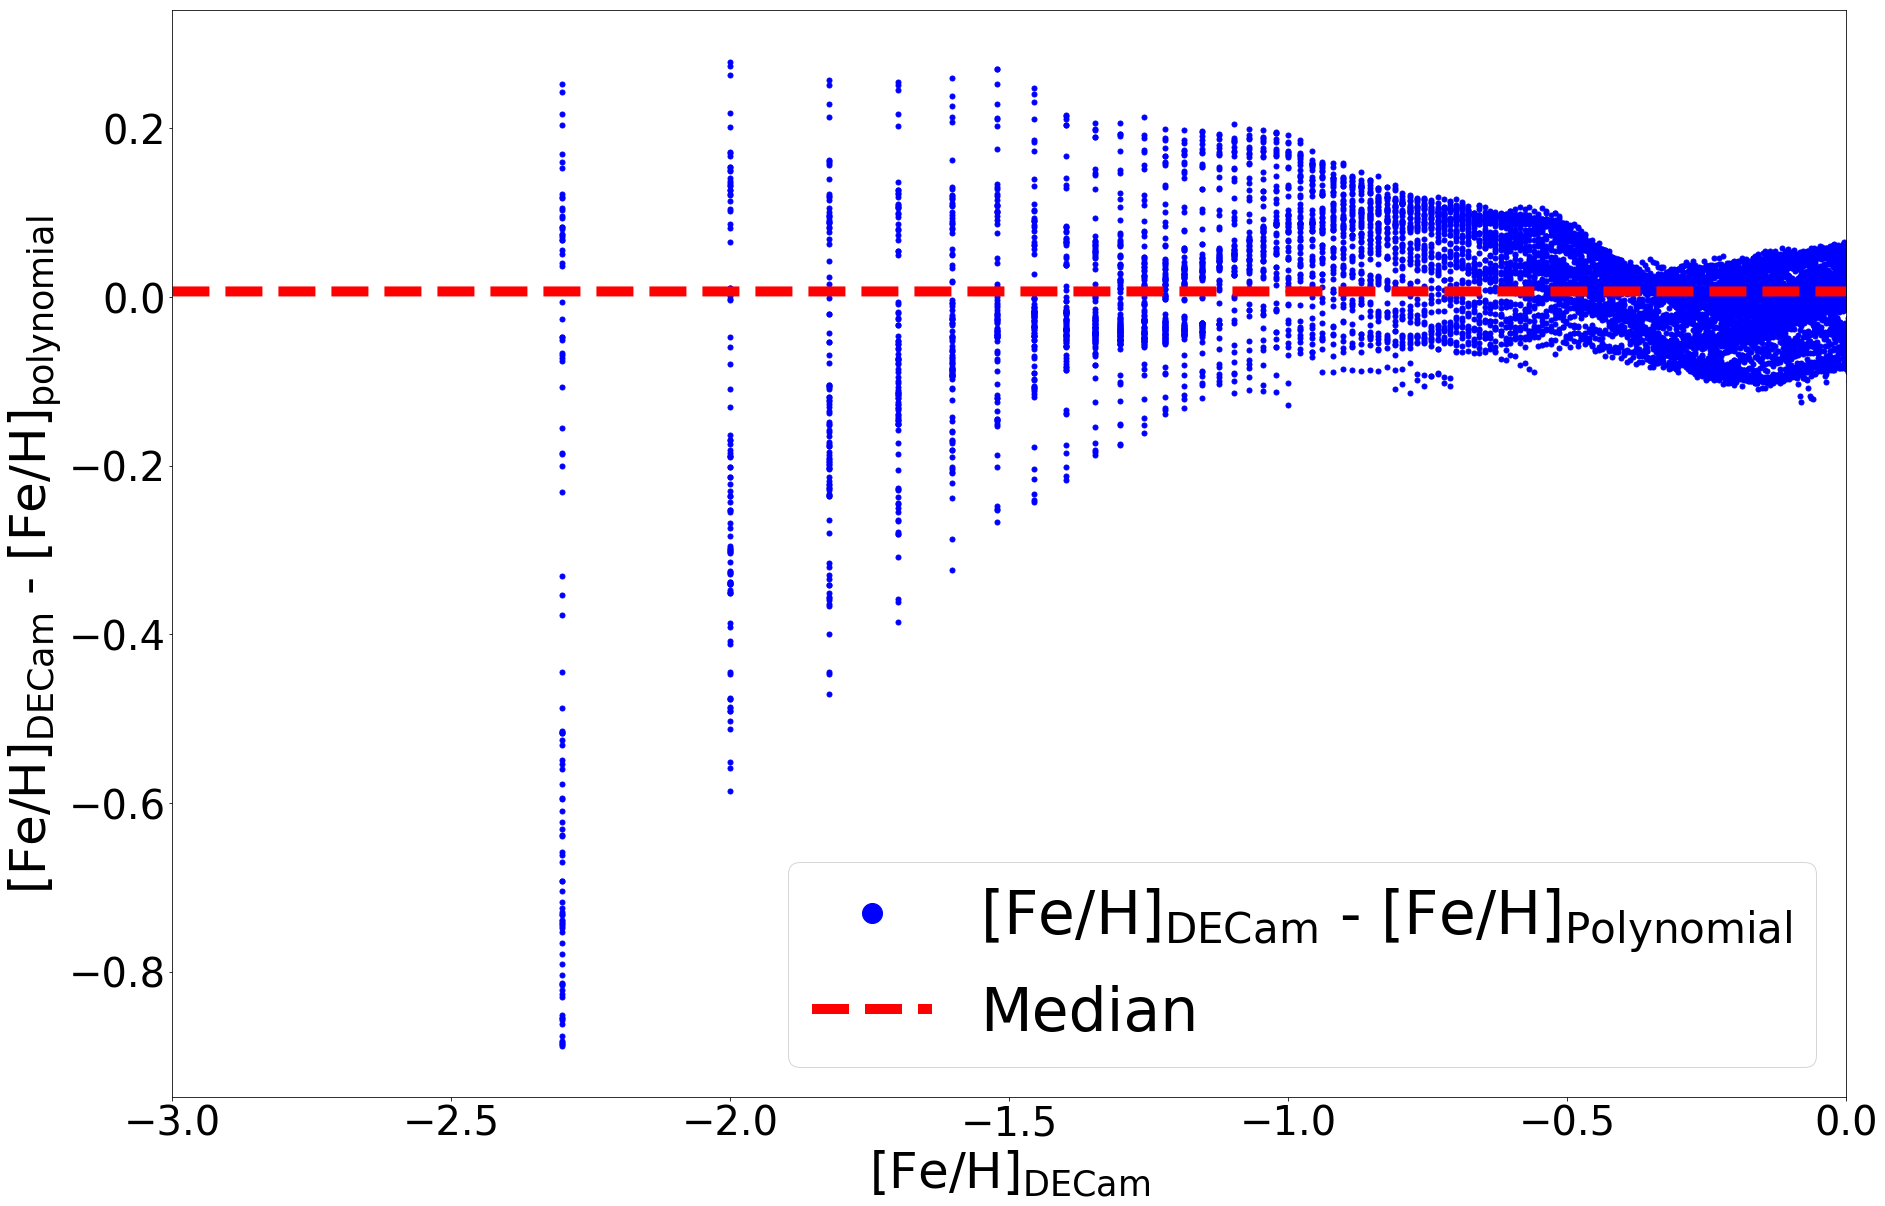

501
0.0067590400348152
['y1' 'y2' 'y1_y2' 'y1sq' 'y2sq' 'y1sq_y2' 'y2sq_y1' 'y1th' 'y2th']
[ -31.80316573   83.05507026  -36.33626095  112.05948183  -80.29311333
 -103.37033309  -80.34825251  112.50100437   29.67121544  -32.70582575]


In [38]:
for index in small:
    delta = feh_des - fitted[index]
    fig, ax = plt.subplots(figsize=(30,20))
    ax.scatter(feh_des,delta,c='b',s=25)
    plt.xlabel('[Fe/H]$_\mathregular{DECam}$',fontsize=50)
    plt.ylabel('[Fe/H]$_\mathregular{DECam}$ - [Fe/H]$_\mathregular{polynomial}$',fontsize=50)
    y=(np.nanmedian(delta))*np.ones(5000)
    plt.plot(x,y,'--',c='r',linewidth=10,label='Median')
    ax.set_xlim(-3,0)
    ax.tick_params(axis='both', which='major', labelsize=40)
    ax.legend(handles=[blue,red],fontsize=60)
    plt.show()
    print(index)
    print(np.nanmedian(delta))
    print(models_str[index])
    print(model_params[index])